# aSPEM Experiment : analysis


Test de différtentes pentes $k$ pour la relation entre $p_bet$ et $\hat{p}$


In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

/home/phantom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/phantom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


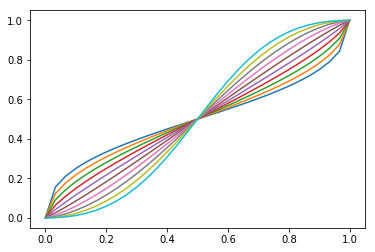

In [5]:
p = np.linspace(0, 1, 31)
def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))
    
#plt.plot(p, sigmoid(4.*logit(p)))
for k in np.logspace(-1, 1, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))

In [6]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [7]:
def mutual_information(p, data, bin_p=5, sub_data=40):
    
    x = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    y = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    support_x = np.linspace(min(x), max(x), bin_p)
    support_y = np.linspace(min(y), max(y), int(len(data)/sub_data))

    summation = 0.00
    for a in range(len(support_x)-1):
        for b in range(len(support_y)-1):
            ind_x = np.where((x>=support_x[a]) & (x<=support_x[a+1]))[0]
            ind_y = np.where((y>=support_y[b]) & (y<=support_y[b+1]))[0]

            px = len(ind_x) / len(x)
            py = len(ind_y) / len(x)
            pxy = len(np.where(np.in1d(ind_x, ind_y)==True)[0]) / len(x)

            if pxy>0.00: summation += pxy * np.log2(pxy / (px*py))


    return summation

In [8]:
Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
tau = np.arange(1, 603, 1)
list_h = 1/tau

def find_r_MI(regress='r', pause=True) :
    

    r_k_s = {}
    for num, s in enumerate(list(set(Full.sujet))):
        print(s, end=' ')

        bet = Full['results'][Full.sujet==s].values.tolist()
        x = np.array(Full['bino'][Full.sujet==s].values.tolist())

        r_k_s[s] = {'sslogit':[]}

        for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :

            r_bet_l, r_bet_ = [], []
            for c in range(0, 3*200-150, 200) : r_bet_l.append([]) ; r_bet_.append([])

            for h in list_h :

                for d, c in enumerate(range(0, 3*200-150, 200)) :
                    x_200, p_hat_200 = x[c:c+200], np.zeros(200)

                    if pause==True :
                        liste = [0, 50, 100, 150, 200]
                        for a in range(len(liste)-1) :
                            p_bar, r_bar, beliefs = bcp.inference(x_200[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                            p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                            p_hat_200[liste[a]:liste[a+1]] = p_hat_p

                    else :
                        p_bar, r_bar, beliefs = bcp.inference(x_200, h=h, p0=.5, r0=1.)
                        p_hat_200, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                
                    
                    if regress=='r' :
                        if num==0 : r_bet_[d].append(r_(p_hat_200.tolist(), bet[c:c+200]))
                        r_bet_l[d].append(r_(sigmoid(k*logit(p_hat_200)), bet[c:c+200]))
                    elif regress=='MI' :
                        if num==0 : r_bet_[d].append(mutual_information(p_hat_200.tolist(), bet[c:c+200]))
                        r_bet_l[d].append(mutual_information(sigmoid(k*logit(p_hat_200)), bet[c:c+200]))
            
            
            if num==0 : r_k_s[s]['sslogit']=r_bet_
            r_k_s[s][k]=r_bet_l
    return r_k_s

In [9]:
r_k_s = find_r_MI(regress='MI', pause=False)

recording = {}
recording['list_h'] = list_h
recording['list_tau'] = tau
recording['list_pente'] = np.logspace(-1, 1, 10, base=2)
recording['r_bet_k'] = r_k_s

import pickle
file = os.path.join('parametre', 'list_MI_bet_logit_200_ss_pauses.pkl')
with open(file, 'wb') as fichier:
    f = pickle.Pickler(fichier)
    f.dump(recording)

SR OP LB FM BMC IP AM DC CS RS TN YK 